# Your first neural networks

## Introduction

For several tasks within the domain of Civil Engineering and Geosciences we might be interested in applying machine learning models to understand some physical processes and phenomena which, for many different reasons, are difficult to interpret. Training a machine learning model will typically involves the following steps:

1. Prepare the data and define the model

3. Train the model.

4. Evaluate the model.

In this notebook, we start with a very simple dataset with an underlying linear pattern. We then train a simple Multilayer Perceptron (MLP) on it and discuss matters related to model complexity and overfitting.

### Python Environment

You will need the package scikit-learn for this workshop. You can import it to one of your existing conda environments from the conda-forge as (i.e., `
conda install -c conda-forge scikit-learn`), or do `pip install scikit-learn` starting from your MUDE environment.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy import interpolate
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

%config InlineBackend.figure_formats = ['svg']

## A simple linear dataset

Machine learning models learn from data and therefore we need data to train our models. For this assignment we will exemplify the use of machine learning in a simple dataset. First, let's create some dummy data. 

We first create a small training dataset (<code>x_train</code>, <code>t_train</code>), with $N=10$. In this case, the ground truth $t$ is:

$$
t = 0.8x+4.75
$$

To make the problem a bit more interesting (and realistic!), we also add Gaussian noise with unit variance to our observations:

$$
t = 0.8x+4.75+\epsilon\quad\quad\epsilon\sim\mathcal{N}(0,1)
$$

Finally, we introduce a **dense validation dataset** to evaluate our model complexity. Normally you would split the original dataset into training and validation sets (as done in PA2.6), but since our dataset is very small this is not a feasible strategy. For this demonstration we will instead simply create more data to use as validation, and to make sure our validation loss is very accurate we will do that with a large number of samples ($N_\mathrm{val}=1000$)

As you can see, this expected loss is based on the squared error, where $t$ is the true value and $y(x)$ is our model.

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p> 

<b>Task 1:</b>

Read the code below, making sure you understand what the data is, as well as the validation set and how it is created. 

Note that since we have only one input and one output we need to slightly reshape the arrays to a form scikit-learn expects. 

Then execute the cells to visualize the data.
</p>
</div>

In [2]:
# Generate some data
np.random.seed(42)
noise_level = 1.0

x_train = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0])
t_train = 0.8 * x_train + 4.75 + np.random.normal(scale=noise_level,size=x_train.shape)

# Get a very dense validation set to give us a good approximation of the real loss
x_val = np.random.uniform(np.min(x_train),np.max(x_train),1000)
t_val = 0.8*x_val + 4.75 + np.random.normal(scale=noise_level,size=x_val.shape)

# Resize the arrays to a shape scikit-learn expects
x_train = x_train.reshape(-1,1)
x_val = x_val.reshape(-1,1)

t_train = t_train.reshape(-1,1)
t_val = t_val.reshape(-1,1)

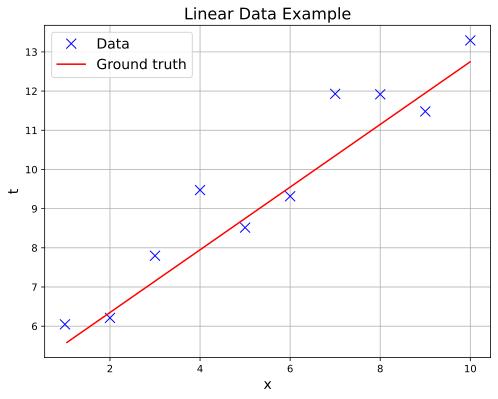

In [3]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x_train.flatten(), t_train, 'x', color='blue', markersize=10, label='Data')
ax.plot(x_val, 0.8*x_val + 4.75, color='red', markersize=10, label='Ground truth')
ax.set_title('Linear Data Example', fontsize=16)
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('t', fontsize=14)
ax.legend(fontsize=14)
ax.grid(True)
plt.show()

## Data normalization

As we have seen in the book, **normalizing our data** and making sure it spans a well-behaved range of values **is essential** when training machine learning models. Here we will use the `StandardScaler` from `scikit-learn`, which means we will center our data around a distribution with zero mean and unit variance.

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p> 

<b>Task 2:</b>

Before training the model you need to standardize your data. To do so you need <code>StandardScaler</code> from <code>sklearn.preprocessing</code> library. Check the [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). 

Make sure to standardize both <code>x_train</code> and <code>x_val</code> arrays and save them in different arrays. 

Using **a different** `StandardScaler`, normalize the outputs `t_train` and `t_val` as well.

Call `fit_transform` to fit the normalizer and transform the data in one go. Call just `transform` to use the same normalizer to scale a different dataset while keeping the normalization coefficients untouched (see tip below).

Then use the provided code block to visualize the normalized data.
</p>
</div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p>

<b>Tip</b>:

You first need to standardize just `x_train` and `t_train`. Only then you can standardize the validation dataset. This will guarantee that the validation data is normalized in the same way as the training data, otherwise the network will get confused when it is time to make predictions. 

With this we also make sure no information "leaks" from the validation set into the training set, which means our validation samples will remain fully unseen by the model during training.
</p>
</div>

In [4]:
input_scaler = StandardScaler()
target_scaler = StandardScaler()

x_train_scaled = input_scaler.fit_transform(x_train)
t_train_scaled = target_scaler.fit_transform(t_train)

x_val_scaled = input_scaler.transform(x_val)
t_val_scaled = target_scaler.transform(t_val)

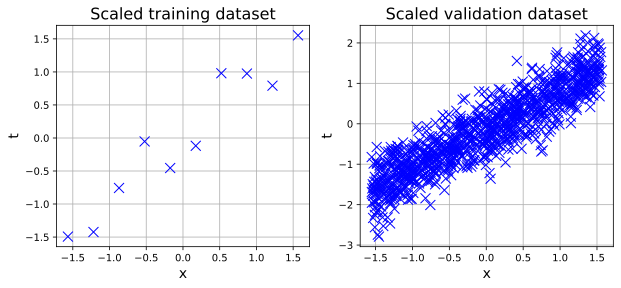

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 4))
ax1.plot(x_train_scaled.flatten(), t_train_scaled, 'x', color='blue', markersize=10)
ax1.set_title('Scaled training dataset', fontsize=16)
ax1.set_xlabel('x', fontsize=14)
ax1.set_ylabel('t', fontsize=14)
ax1.grid(True)

ax2.plot(x_val_scaled.flatten(), t_val_scaled, 'x', color='blue', markersize=10)
ax2.set_title('Scaled validation dataset', fontsize=16)
ax2.set_xlabel('x', fontsize=14)
ax2.set_ylabel('t', fontsize=14)
ax2.grid(True)

plt.show()

## Create and train a neural network

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p> 

<b>Task 3:</b>

We now try to fit this data with a Multilayer Perceptron (MLP), also known as a Feedforward Neural Network (FNN), with input, hidden and output layers, each with a specified number of neurons. For such models we also need to specify some hyperparameters. In Scikit-learn, the MLP is defined in the <code>MLPRegressor</code> class, you can see the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html).
**You should start with a linear MLP, so with** `identity` **activation and without hidden layers.**

</p>
</div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p>

<b>Tip</b>: 

You can create the model using the method and two arguments.

Specifying <code>hidden_layer_sizes=()</code> implies that the Neural Network does not have hidden layers. There is only one input layer and one output layer and therefore it is transforming directly $x$ into $y$ without going through intermediate steps.

Specifying <code>activation = 'identity'</code> means that we are not going to alter the output of the model with an activation function such as ReLU, tanh, or sigmoid (the most popular activation functions for Neural Networks).
</p>
</div>

In [6]:
model = MLPRegressor(hidden_layer_sizes=(), activation='identity') 

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p> 

<b>Task 4:</b> 

So far the model has not been trained yet. This is something we can do using the <code>partial_fit</code> method and then make predictions with the <code>predict</code> method. Fill in the code below to find the model predictions for the training and validation sets (defined above)
</p>
</div>

In [7]:
n_epochs = 10000
N_print = 10**(int(np.log10(n_epochs)) - 1)

for epoch in range(n_epochs):
    model.partial_fit(x_train_scaled, t_train_scaled.flatten())

    MLP_prediction = model.predict(x_train_scaled)
    MLP_valprediction = model.predict(x_val_scaled)
    
    if epoch%N_print==0 or epoch==n_epochs-1: 
        print((f'Epoch: {epoch:6d}/{n_epochs}, '
               + f'MSE: {mean_squared_error(t_train_scaled, MLP_prediction.reshape(-1,1)):0.4f}, '
               + f'Real loss: {mean_squared_error(t_val_scaled, MLP_valprediction):0.4f}'))

Epoch:      0/10000, MSE: 1.4264, Real loss: 1.1585


Epoch:   1000/10000, MSE: 0.1293, Real loss: 0.2100


Epoch:   2000/10000, MSE: 0.0832, Real loss: 0.1950


Epoch:   3000/10000, MSE: 0.0831, Real loss: 0.1952


Epoch:   4000/10000, MSE: 0.0831, Real loss: 0.1952


Epoch:   5000/10000, MSE: 0.0831, Real loss: 0.1952


Epoch:   6000/10000, MSE: 0.0831, Real loss: 0.1952


Epoch:   7000/10000, MSE: 0.0831, Real loss: 0.1952


Epoch:   8000/10000, MSE: 0.0831, Real loss: 0.1952


Epoch:   9000/10000, MSE: 0.0831, Real loss: 0.1952


Epoch:   9999/10000, MSE: 0.0831, Real loss: 0.1952


<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p>

<b>Tip</b>:  

<b>Be careful about re-running cells!</b> If you executed the cell above more than once, you may have noticed that the values of loss sand MSE stopped changing. Note carefully that in the for loop above we are operating on <code>model</code>, which is an object with type <code>sklearn.neural_network._multilayer_perceptron.MLPRegressor</code>. You can "ask" the model about its status by checking how many epochs have been evaluated with the <code>t_</code> attribute (try it!). If you need to "reset" the model, simply redefine the variable <code>model</code>.

</p>
</div>

Notice how the loss function progressively decreases. That means that our model is indeed learning! That is, it is reducing its error.

Also notice how the `Real loss` value decreases with time. Again remember this is the value of the loss function obtained with a very dense validation dataset. Notice how the training loss is usually lower than the real loss. This is expected, as the training loss is obtained with a very small dataset and is therefore overly optimistic (on average).

## Making predictions

Now we can plot the predictions from our model against the data. **Remember that we normalized our data** and used the scaled version of the dataset for training. But we actually want to **plot predictions in the unnormalized space**. So we need to do some extra back-and-forth with our normalizers:

- The network wants to see normalized inputs. So if we set up a `linspace` in the original $x$ we need to **normalize it**
- The network then makes predictions $y(x)$, but because we train with normalized targets, $y(x)$ will also "live" in the normalized space
- To go back to the original $x-y$ space we therefore need to **de-normalize our predictions**

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p> 

<b>Task 5:</b> 

Make predictions using the trained network in the range $x\in[1,10]$. Use the `transform` and `inverse_transform` functions of your normalizers to transform between original and normalized spaces. Then use the code already provided to look at your predictions and compare them with the ground truth.

</p>
</div>

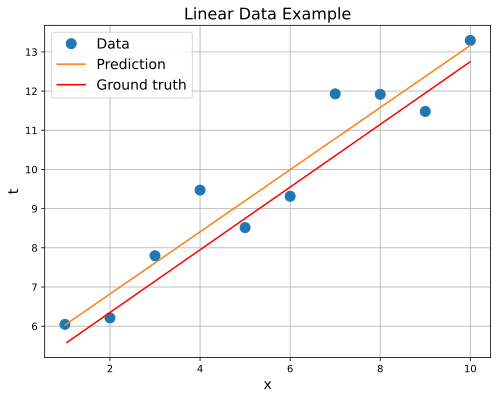

In [8]:
# Get a dense linspace to make predictions
x_pred = np.linspace(1,10,1000).reshape(-1,1)

# Normalize the input
x_pred_scaled = input_scaler.transform(x_pred)

# Predict
y_pred_scaled = model.predict(x_pred_scaled).reshape(-1,1)

# De-normalize the outputs
y_pred = target_scaler.inverse_transform(y_pred_scaled)

# Plot the data
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x_train, t_train, ".", markersize=20, label="Data")
ax.plot(x_pred, y_pred, "-", markersize=10, label="Prediction")
ax.plot(x_val, 0.8*x_val + 4.75, color='red', markersize=10, label='Ground truth')

# Add a title and axis labels
ax.set_title("Linear Data Example", fontsize=16)
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("t", fontsize=14)

# Add a legend
ax.legend(fontsize=14)

# Add a grid
ax.grid(True)

# Show the plot
plt.show()

We can then print the weights of the model:

In [9]:
print(f'Model coefficients: {model.coefs_}')
print(f'Model intercepts: {model.intercepts_}')

Model coefficients: [array([[0.95755973]])]
Model intercepts: [array([1.01348728e-16])]


<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p> 

<b>Question 1:</b> 

We were expecting to see something close to $0.8$ for the coefficient and $4.75$ for the intercept. Can you think of an explanation for why we see very different values?

</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p> <b>Solution:</b>   
<p>

Since the network learns to map **normalized** inputs to **normalized** outputs, the weights attain different values than what is expected. But de-normalizing the outputs will still give a straight line that is very close to the one we would expect, as can be seen in the plot.

</p>
</div>

## Increase model complexity

Now let us see whether it is a good idea to use a much more flexible model in this case.

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p> 

<b>Task 6:</b> 

Initialize and train another MLP, but this time with **two hidden layers with 50 units each** and `activation=relu`.

Then plot model predictions as you did last time.
</p>
</div>

In [10]:
model = MLPRegressor(hidden_layer_sizes=(50,50), activation='relu') 

n_epochs = 10000
N_print = 10**(int(np.log10(n_epochs)) - 1)

for epoch in range(n_epochs):
    model.partial_fit(x_train_scaled, t_train_scaled.flatten())

    MLP_prediction = model.predict(x_train_scaled)
    MLP_valprediction = model.predict(x_val_scaled)
    
    if epoch%N_print==0 or epoch==n_epochs-1: 
        print((f'Epoch: {epoch:6d}/{n_epochs}, '
               + f'MSE: {mean_squared_error(t_train_scaled, MLP_prediction.reshape(-1,1)):0.4f}, '
               + f'Real loss: {mean_squared_error(t_val_scaled,MLP_valprediction):0.4f}'))

Epoch:      0/10000, MSE: 0.8826, Real loss: 0.9110


Epoch:   1000/10000, MSE: 0.0002, Real loss: 0.2535


Epoch:   2000/10000, MSE: 0.0000, Real loss: 0.2537


Epoch:   3000/10000, MSE: 0.0000, Real loss: 0.2531


Epoch:   4000/10000, MSE: 0.0000, Real loss: 0.2537


Epoch:   5000/10000, MSE: 0.0000, Real loss: 0.2535


Epoch:   6000/10000, MSE: 0.0000, Real loss: 0.2538


Epoch:   7000/10000, MSE: 0.0000, Real loss: 0.2541


Epoch:   8000/10000, MSE: 0.0000, Real loss: 0.2525


Epoch:   9000/10000, MSE: 0.0000, Real loss: 0.2540


Epoch:   9999/10000, MSE: 0.0000, Real loss: 0.2549


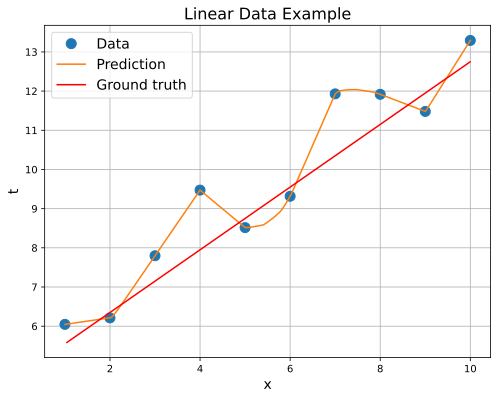

In [11]:
# Get a dense linspace to make predictions
x_pred = np.linspace(1,10,1000).reshape(-1,1)

# Normalize the input
x_pred_scaled = input_scaler.transform(x_pred)

# Predict
y_pred_scaled = model.predict(x_pred_scaled).reshape(-1,1)

# De-normalize the outputs
y_pred = target_scaler.inverse_transform(y_pred_scaled)

# Plot the data
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x_train, t_train, ".", markersize=20, label="Data")
ax.plot(x_pred, y_pred, "-", markersize=10, label="Prediction")
ax.plot(x_val, 0.8*x_val + 4.75, color='red', markersize=10, label='Ground truth')

# Add a title and axis labels
ax.set_title("Linear Data Example", fontsize=16)
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("t", fontsize=14)

# Add a legend
ax.legend(fontsize=14)

# Add a grid
ax.grid(True)

# Show the plot
plt.show()

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p> 

<b>Question 2:</b> 

What happened to the real loss? Is it higher or lower than before? Is this model good? Think about it: **we know the ground truth is actually linear**. Would it make sense to have such a flexible model here? Is the validation loss giving you a valuable hint about it?

</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p> <b>Solution:</b>   
<p>
The real loss is higher than before because the model is overfitting. It does not make sense to have something non-linear fitting data that is actually coming from a linear model. Of course, in practice we would not know the ground truth, but the fact that the validation loss increases gives us a valuable hint that the very complex model is not appropriate.
</p>
</div>

## Controlling model complexity

The previous model is way too flexible and we ended up overfitting the noise in the data. So we should use a smaller model, but tweaking the architecture can be annoying. 

For this part you can try something different: **Keep the same network size but add an $L_2$ regularization term** to your model. Check the book and related videos again if you need a refresher on what $L_2$ regularization is, but in a nutshell it introduces a new hyper-parameter $\alpha$ that controls model complexity by penalizing very large weights ($\alpha=0$ recovers the very complex model from the previous task). Picking a good value for $\alpha$ is another instance of **model selection**, and should be done by **minimizing validation loss**.

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p> 

<b>Task 7:</b> 

In `scikit-learn` you can use $L_2$ regularization by setting the `alpha` parameter you give to `MLPRegressor` to a desired value. Complete the missing code in the blocks below by copy-pasting from previous tasks.

Try different values in the interval $0<\alpha\leq 3$ and see what happens to model complexity. 

What is the value of $\alpha$ that leads to the lowest value for the real loss?
</p>
</div>

In [12]:
model = MLPRegressor(hidden_layer_sizes=(50,50), activation='relu',alpha=0.2) 

n_epochs = 10000
N_print = 10**(int(np.log10(n_epochs)) - 1)

for epoch in range(n_epochs):
    model.partial_fit(x_train_scaled, t_train_scaled.flatten())

    MLP_prediction = model.predict(x_train_scaled)
    MLP_valprediction = model.predict(x_val_scaled)
    
    if epoch%N_print==0 or epoch==n_epochs-1: 
        print((f'Epoch: {epoch:6d}/{n_epochs}, '
               + f'MSE: {mean_squared_error(t_train_scaled, MLP_prediction.reshape(-1,1)):0.4f}, '
               + f'Real loss: {mean_squared_error(t_val_scaled,MLP_valprediction):0.4f}'))

Epoch:      0/10000, MSE: 0.9244, Real loss: 0.8118


Epoch:   1000/10000, MSE: 0.0721, Real loss: 0.2062


Epoch:   2000/10000, MSE: 0.0772, Real loss: 0.2023


Epoch:   3000/10000, MSE: 0.0783, Real loss: 0.2010


Epoch:   4000/10000, MSE: 0.0784, Real loss: 0.2006


Epoch:   5000/10000, MSE: 0.0784, Real loss: 0.2007


Epoch:   6000/10000, MSE: 0.0785, Real loss: 0.2006


Epoch:   7000/10000, MSE: 0.0784, Real loss: 0.2007


Epoch:   8000/10000, MSE: 0.0784, Real loss: 0.2009


Epoch:   9000/10000, MSE: 0.0785, Real loss: 0.2006


Epoch:   9999/10000, MSE: 0.0784, Real loss: 0.2002


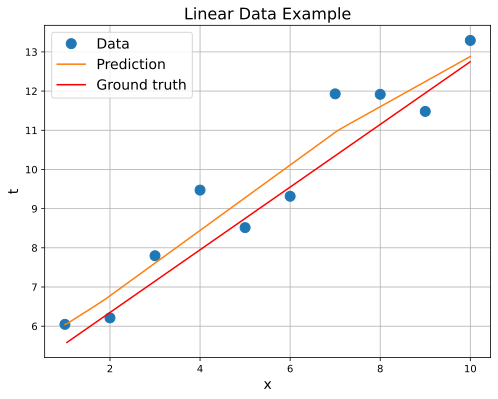

In [13]:
# Get a dense linspace to make predictions
x_pred = np.linspace(1,10,1000).reshape(-1,1)

# Normalize the input
x_pred_scaled = input_scaler.transform(x_pred)

# Predict
y_pred_scaled = model.predict(x_pred_scaled).reshape(-1,1)

# De-normalize the outputs
y_pred = target_scaler.inverse_transform(y_pred_scaled)

# Plot the data
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x_train, t_train, ".", markersize=20, label="Data")
ax.plot(x_pred, y_pred, "-", markersize=10, label="Prediction")
ax.plot(x_val, 0.8*x_val + 4.75, color='red', markersize=10, label='Ground truth')

# Add a title and axis labels
ax.set_title("Linear Data Example", fontsize=16)
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("t", fontsize=14)

# Add a legend
ax.legend(fontsize=14)

# Add a grid
ax.grid(True)

# Show the plot
plt.show()

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p> 

<b>Question 3:</b> 

How close is the model with the lowest validation loss to your first linear model? Is this a reassuring result? 

</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p> <b>Solution:</b>   
<p>
The model is now very close to linear. This is a good sign, the validation loss led us to the correct model!
</p>
</div>

Neural networks can be very flexible and that is usually a good thing. But at the end of the day you want a model that performs **your specific task** as well as possible, and sometimes that means a very simple linear model is all what you need.

It is nice to see that even if we do not actually know how complex the underlying patterns in our data are, if we have **a good validation dataset** we can rely on it to tell us how flexible our model should be.

> By Iuri Rocha, Delft University of Technology. CC BY 4.0, more info [on the Credits page of Workbook](https://mude.citg.tudelft.nl/workbook-2025/credits.html)